# Ingeniería de características a datos tabulados

Este es el proceso inmediatamente previo al entrenamiento de los modelos. Estos son operaciones matemáticas que se aplican a un conjunto de datos con el fin de optimizar una función de pérdida. Dada la naturaleza matemática de los algoritmos, los datos han de ser aptos para ser operados, según lo requiera el modelo.

- Se etiquetará el conjunto de datos.
- Se tratarán los datos vacíos.
- Se transformarán las características.
- Se seleccionarán las características.


In [1]:
#Importando librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from fefunctions import *
import pandas as pd
from random import sample
import json
import mlflow
import warnings
import math
import sys
sys.path.append('../../')
import plotly.graph_objects as go
from Python.Style.styles import  *
from Python.Preprocessing.funcs import  *
from tensorflow.keras.applications.vgg16 import VGG16
from Python.FeatureEngeeniering.Fresnel.fresnelFeature import cord2disV2
import Python.Private.constants as private_constants


In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.float_format',  '{:,.8f}'.format)

In [4]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [5]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

## Leyendo datos

In [6]:
#Leyendo data de equipos
mesh_gateways = pd.read_parquet("../../Data/DataMart/Base/cContainer.parquet")
mesh_routers = pd.read_parquet("../../Data/DataMart/Base/rContainer.parquet")
mesh_clients = pd.read_parquet("../../Data/DataMart/Base/mContainer.parquet")

## Imputación de datos

### Imputación coordenadas mesh clients

In [7]:
#Transformando tipos de datos
#mesh_gateways['serialNumber'] = mesh_gateways['serialNumber'].astype(str)
#mesh_routers['serialNumber'] = mesh_routers['serialNumber'].astype(str)
#mesh_clients['serialNumber'] = mesh_clients['serialNumber'].astype(str)
mesh_gateways['fDate'] = mesh_gateways['fDate'].astype(str)
mesh_routers['fDate'] = mesh_routers['fDate'].astype(str)
mesh_clients['fDate'] = mesh_clients['fDate'].astype(str)

In [8]:
#Vacios en coordenadas
mg_empty_cords = mesh_gateways[mesh_gateways['latitude'].isna() | mesh_gateways['longitude'].isna()]
mr_empty_cords = mesh_routers[mesh_routers['latitude'].isna() | mesh_routers['longitude'].isna()]
mc_empty_cords = mesh_clients[(mesh_clients['latitude'].isna() | mesh_clients['longitude'].isna()) & (mesh_clients['Desplegado'] == 'Sí')]
print("Cantidad de filas sin coordenadas mesh gateways: ", len(mg_empty_cords))
print("Cantidad de filas sin coordenadas mesh routers: ", len(mr_empty_cords))
print("Cantidad de filas sin coordenadas mesh clients: ", len(mc_empty_cords))

Cantidad de filas sin coordenadas mesh gateways:  0
Cantidad de filas sin coordenadas mesh routers:  0
Cantidad de filas sin coordenadas mesh clients:  3172


In [9]:
#Filtrando
mesh_clients = mesh_clients[mesh_clients['Desplegado'] == 'Sí']
mesh_clients_no_cords = mesh_clients[mesh_clients['latitude'].isna() | mesh_clients['longitude'].isna()]

In [10]:
mesh_clients_no_cords['jump'] = mesh_clients_no_cords['path'].apply(gettingJump)

In [ ]:
#No cords, no jump
mc_no_cords_no_jump = mesh_clients_no_cords[mesh_clients_no_cords['jump'].isna()]
print("Cantidad de filas sin coordenadas y sin salto: ", len(mc_no_cords_no_jump))
mc_no_cords_no_jump.head()

In [12]:
#Guardando temporal para visualización
mc_no_cords_no_jump.to_csv("../../Data/DataMart/temp/mc_no_cords_no_jump.csv", index=False)
mesh_clients_no_cords.to_csv("../../Data/DataMart/temp/mc_no_cords.csv", index=False)

Según una inspección se determina que es despreciable la cantidad de filas removidas del dataset al retirar los medidores mc_no_cords_no_jump. Al no existir alguna referencia que permita la imputación de las coordenadas se procede de esa manera.

In [ ]:
#Removiendo no jump
mc_temp_just_cords = mesh_clients[~mesh_clients['latitude'].isna() & ~mesh_clients['longitude'].isna()][["serialNumber","latitude","longitude","fDate"]]
temp_all_jumps = pd.concat([mesh_gateways[["serialNumber","latitude","longitude","fDate"]], mesh_routers[["serialNumber","latitude","longitude","fDate"]],\
                            mc_temp_just_cords], ignore_index=True)

mesh_clients_no_cords = mesh_clients_no_cords[~mesh_clients_no_cords['jump'].isna()]

#Agregando coordenadas del salto

mesh_clients_no_cords['fDate'] = mesh_clients_no_cords['fDate'].astype(str)
temp_all_jumps['fDate'] = temp_all_jumps['fDate'].astype(str)

jumps_reference = mesh_clients_no_cords[["meterNo","jump", "fDate"]].merge(temp_all_jumps, left_on=['jump','fDate'], right_on=['serialNumber','fDate'],\
                                                                           suffixes=('', '_jump'), how='left')

jumps_reference["Peso jump"] = jumps_reference.groupby(["meterNo","jump","latitude","longitude"])["fDate"].transform('count')
jumps_reference[["lat_jump_mean","lon_jump_mean"]] = jumps_reference.groupby(["meterNo"])[["latitude","longitude"]].transform('mean')

#jumps_reference.reset_index(inplace=True)

jumps_reference.head()

#### Visualizando imputación de coordenadas

In [14]:
#Visualizando imputación
tempMeter = "F-70069"
temp_jumps_reference = jumps_reference[jumps_reference["meterNo"] == tempMeter]

In [15]:
mapa_datos = {
    "Jumps" : {
        "color" : mClr,
        "df" : temp_jumps_reference,
        "coords" : ["latitude","longitude"],
        "size" : "Peso jump",
        "hover_field" : "jump"
    },
    "NewCords" : {
        "color" : sClr1,
        "df" : temp_jumps_reference,
        "coords" : ["lat_jump_mean","lon_jump_mean"],
        "size" : 20,
        "hover_field" : "meterNo"
    }
}

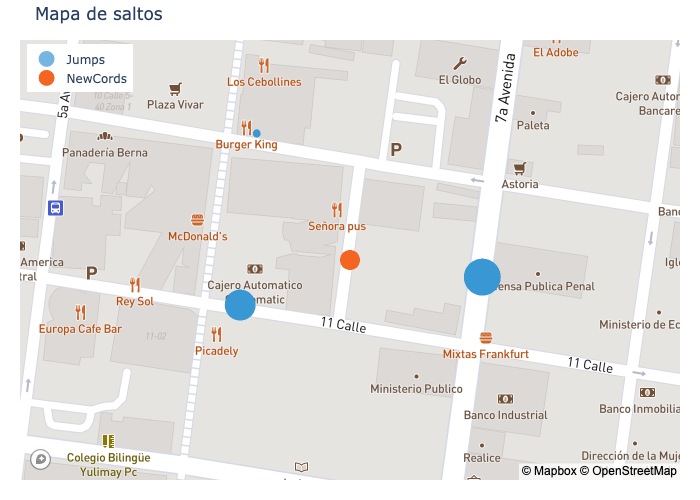

In [16]:
crear_mapa(mapa_datos, private_constants.mapbox_access_token, [temp_jumps_reference['latitude'].mean(), temp_jumps_reference['longitude'].mean()],\
           17, "Mapa de saltos", False)

El punto naranja muestra el valor que se imputará al correspondiente MC. Que corresponde a la media de los valores de coordenadas de salto.

In [17]:
#Agregando columna de registro FE y eliminando mc_no_cords_no_jump
mesh_clients["FE-Comments"] = [[]]*len(mesh_clients)
iLen = len(mesh_clients)
mc_to_remove = mesh_clients[mesh_clients['serialNumber'].isin(mc_no_cords_no_jump['serialNumber'])]
mesh_clients = mesh_clients[~mesh_clients['serialNumber'].isin(mc_no_cords_no_jump['serialNumber'])]
fLen = len(mesh_clients)
print("Cantidad de registros eliminados: ", iLen - fLen)

Cantidad de registros eliminados:  135


In [18]:
#Acondicionando jumps_reference previo a imputación
jumps_reference['FE-Comments'] = [["Coords imputed"]] * len(jumps_reference)
jumps_reference['latitude'] = jumps_reference['lat_jump_mean']
jumps_reference['longitude'] = jumps_reference['lon_jump_mean']

In [19]:
#Imputando coordenadas
mesh_clients = updateDf(mesh_clients, jumps_reference, keyCols = ["meterNo","fDate"], updateCols = ["latitude","longitude","FE-Comments"])

In [20]:
#Chequeando imputación
temp = mesh_clients[mesh_clients["FE-Comments"].apply(lambda x: "Coords imputed" in x)]
temp.to_csv("../../Data/DataMart/temp/mc_imputed.csv", index=False)

In [21]:
#Vacios en coordenadas
mg_empty_cords = mesh_gateways[mesh_gateways['latitude'].isna() | mesh_gateways['longitude'].isna()]
mr_empty_cords = mesh_routers[mesh_routers['latitude'].isna() | mesh_routers['longitude'].isna()]
mc_empty_cords = mesh_clients[(mesh_clients['latitude'].isna() | mesh_clients['longitude'].isna()) & (mesh_clients['Desplegado'] == 'Sí')]
print("Cantidad de filas sin coordenadas mesh gateways: ", len(mg_empty_cords))
print("Cantidad de filas sin coordenadas mesh routers: ", len(mr_empty_cords))
print("Cantidad de filas sin coordenadas mesh clients: ", len(mc_empty_cords))

Cantidad de filas sin coordenadas mesh gateways:  0
Cantidad de filas sin coordenadas mesh routers:  0
Cantidad de filas sin coordenadas mesh clients:  0


### Imputación de Path, Layer, CollectorNm

Se determinó que existen valores de Path que contienen información errónea, principalmente, que el último elemento en el string separado por comas no corresponde al serialNumber del equipo en cuestión. Dada la importancia del Path para las otras imputaciones, se comenzará por reparar esta inconsistencia.

In [22]:
def path_correction(row):
    path = row["path"]
    current_sn = row["serialNumber"]
    fe_comment = row["FE-Comments"]
    if path is None:
        return None, fe_comment, None
    else:
        path = path.split(",")
        if int(path[-1]) == int(current_sn):
            return path, fe_comment, len(path)
        else:
            new_path = path + [str(current_sn)]
            return new_path, fe_comment + ["Path fixed"], len(new_path)

In [23]:
#Tratando path routers
temp_mrouter = mesh_routers.copy()
temp_mrouter["FE-Comments"] = [[]]*len(temp_mrouter)
temp_mrouter[["fixed_path","FE-Comments","path_length"]] = temp_mrouter.apply(path_correction, axis=1, result_type="expand")

In [24]:
#Tratando path clients
temp_mclient = mesh_clients.copy()
temp_mclient[['fixed_path','FE-Comments','path_length']] = temp_mclient.apply(path_correction, axis=1, result_type="expand")

In [25]:
temp_mclient[temp_mclient['FE-Comments'].apply(lambda x: "Path fixed" in x)].to_csv("../../Data/DataMart/temp/mc_fixed_path.csv", index=False)

In [26]:
#Agregando path a mesh gateways
mesh_gateways["fixed_path"] = mesh_gateways['serialNumber'].apply(lambda x: [str(x)])
mesh_gateways["FE-Comments"] = [[]]*len(mesh_gateways)
mesh_gateways["path_length"] = 1

#### Visualizando imputación basada en vecino más cercano

In [ ]:
#Total con path
total_with_path = pd.concat([temp_mrouter[["latitude","longitude","fixed_path"]], temp_mclient[["latitude","longitude","fixed_path"]],\
                             mesh_gateways[["latitude","longitude","fixed_path"]]], ignore_index=True)
total_with_path = total_with_path[~total_with_path['fixed_path'].isna()]
total_with_path.drop_duplicates(subset = ["latitude","longitude"], inplace=True)
total_with_path.head()

In [ ]:
#Preparando para visualizar en mapa
current_mc = "F-92519"
tdf = temp_mclient[temp_mclient['meterNo'] == current_mc]
tlat, tlon = temp_mclient[temp_mclient['meterNo'] == current_mc][["latitude","longitude"]].values[0]
distancias = total_with_path.apply(lambda x: cord2disV2(tlat, tlon, x["latitude"], x["longitude"]), axis=1)
distancias = distancias.sort_values().head(5)
nearest_points = total_with_path.loc[distancias.index]
nearest_points.reset_index(inplace=True)
nearest_point = nearest_points.head(1)
nearest_point = pd.concat([nearest_point,nearest_point], ignore_index=True)
nearest_points

In [29]:
mapa_datos = {
    "NearestPoints" : {
        "color" : sClr3,
        "df" : nearest_points,
        "coords" : ["latitude","longitude"],
        "size" : 15,
        "hover_field" : "fixed_path"
    },
    "CurrentPoint" : {
        "color" : mClr,
        "df" : tdf,
        "coords" : ["latitude","longitude"],
        "size" : 15,
        "hover_field" : "meterNo"
    },
    "NearestPoint" : {
        "color" : sClr1,
        "df" : nearest_point,
        "coords" : ["latitude","longitude"],
        "size" : 15,
        "hover_field" : "latitude"
    }
}

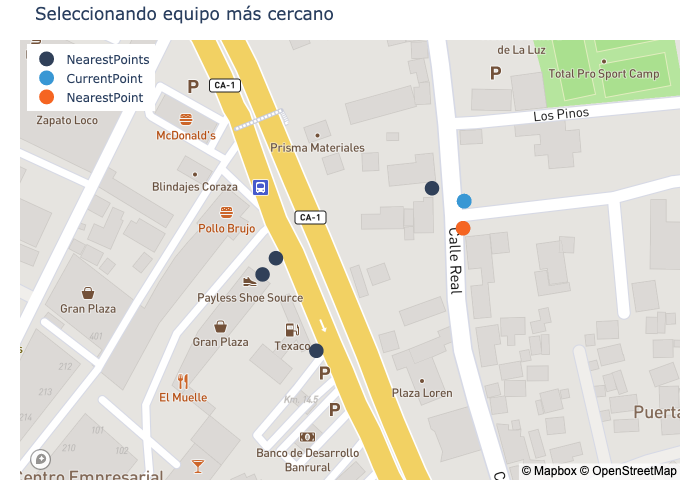

In [30]:
#Creando mapa
crear_mapa(mapa_datos, private_constants.mapbox_access_token, [nearest_points['latitude'].mean(), nearest_points['longitude'].mean()],\
           17, "Seleccionando equipo más cercano", False)

In [31]:
#Imputando path
temp_no_path = temp_mclient[temp_mclient['fixed_path'].isna()]

for i in temp_no_path["meterNo"].unique():
    #Seleccionando equipo sin path
    tdf = temp_no_path[temp_no_path['meterNo'] == i]
    tlat, tlon = tdf[["latitude","longitude"]].values[0]
    current_sn = tdf["serialNumber"].values[0]
    #Calculando distancias
    distancias = total_with_path.apply(lambda x: cord2disV2(tlat, tlon, x["latitude"], x["longitude"]), axis=1)
    distancias = distancias.sort_values()
    new_path = total_with_path.loc[distancias.index[0]]["fixed_path"] + [str(current_sn)]
    #Asignando valores nuevos
    temp_no_path.loc[temp_no_path['meterNo'] == i, "fixed_path"] = temp_no_path.loc[temp_no_path['meterNo'] == i, "fixed_path"].apply(lambda x: new_path)
    temp_no_path.loc[temp_no_path['meterNo'] == i, "FE-Comments"] = temp_no_path.loc[temp_no_path['meterNo'] == i, "FE-Comments"].apply(lambda x: x + ["Path imputed"])
    temp_no_path.loc[temp_no_path['meterNo'] == i, "path_length"] = len(new_path)

In [32]:
#Actualizando en df
temp_mclient = updateDf(temp_mclient, temp_no_path, keyCols = ["meterNo","fDate"], updateCols = ["fixed_path","path_length","FE-Comments"])
#Guardando para chequeo
temp_mclient[temp_mclient['FE-Comments'].apply(lambda x: "Path imputed" in x)].to_csv("../../Data/DataMart/temp/mc_imputed_path.csv", index=False)

In [33]:
print(f"Cantidad de MC sin path: {len(temp_mclient[temp_mclient['fixed_path'].isna()])}")

Cantidad de MC sin path: 0


In [34]:
#Función para imputación de layer
def imputing_layer(row):
    current_layer = row["layer"]
    current_path_length = row["path_length"]
    current_fe_comment = row["FE-Comments"]
    if math.isnan(current_layer):
        return current_path_length - 1, current_fe_comment + ["Layer imputed"]
    else:
        return current_layer, current_fe_comment


In [35]:
#Cantidad de equipos sin capa
print(f"Cantidad de MR sin layer: {len(temp_mrouter[temp_mrouter['layer'].isna()])}")
print(f"Cantidad de MC sin layer: {len(temp_mclient[temp_mclient['layer'].isna()])}")

Cantidad de MR sin layer: 37
Cantidad de MC sin layer: 8842


In [36]:
#Imputando capa
temp_mrouter[["layer","FE-Comments"]] = temp_mrouter.apply(imputing_layer, axis=1, result_type="expand")
temp_mclient[["layer","FE-Comments"]] = temp_mclient.apply(imputing_layer, axis=1, result_type="expand")
#Guardando para chequeo
temp_mrouter[temp_mrouter['FE-Comments'].apply(lambda x: "Layer imputed" in x)].to_csv("../../Data/DataMart/temp/mr_imputed_layer.csv", index=False)
temp_mclient[temp_mclient['FE-Comments'].apply(lambda x: "Layer imputed" in x)].to_csv("../../Data/DataMart/temp/mc_imputed_layer.csv", index=False)

In [37]:
#Cantidad de equipos sin capa
print(f"Cantidad de MR sin layer: {len(temp_mrouter[temp_mrouter['layer'].isna()])}")
print(f"Cantidad de MC sin layer: {len(temp_mclient[temp_mclient['layer'].isna()])}")

Cantidad de MR sin layer: 0
Cantidad de MC sin layer: 0


In [38]:
#Imputando mesh gateways
print(f"Cantidad de filas en MR sin CollectorNm: {len(temp_mrouter[temp_mrouter['CollectorNm']=='None'])}")
print(f"Cantidad de filas en MC sin Collector Nm: {len(temp_mclient[temp_mclient['CollectorNm']=='None'])}")

Cantidad de filas en MR sin CollectorNm: 0
Cantidad de filas en MC sin Collector Nm: 8376


In [39]:
#Referencia de mesh gateways y serial number
mesh_gateways = mesh_gateways[mesh_gateways["toDelete"] == False]
collNm_ref = mesh_gateways[["serialNumber","CollectorNm"]].drop_duplicates()
len(collNm_ref)

82

In [40]:
#Función para imputación de CollectorNm
def imputing_collector(row):
    current_collectorNm = row["CollectorNm"]
    path_mgateway = row["fixed_path"][0]
    current_fe_comment = row["FE-Comments"]
    if current_collectorNm == "None":
        try:
            return collNm_ref[collNm_ref["serialNumber"] == int(path_mgateway)]["CollectorNm"].values[0], current_fe_comment + ["CollectorNm imputed"]
        except:
            return current_collectorNm, current_fe_comment + ["CollectorNm not found"]
    else:
        return current_collectorNm, current_fe_comment

In [ ]:
#Aplicando función a mesh clients
temp_mclient[["CollectorNm","FE-Comments"]] = temp_mclient.apply(imputing_collector, axis=1, result_type="expand")
#Guardando para chequeo
temp_mclient[temp_mclient['FE-Comments'].apply(lambda x: "CollectorNm imputed" in x)].head(3)

In [42]:
#Imputando mesh gateways
print(f"Cantidad de filas en MR sin CollectorNm: {len(temp_mrouter[temp_mrouter['CollectorNm']=='None'])}")
print(f"Cantidad de filas en MC sin Collector Nm: {len(temp_mclient[temp_mclient['CollectorNm']=='None'])}")

Cantidad de filas en MR sin CollectorNm: 0
Cantidad de filas en MC sin Collector Nm: 0


In [43]:
#Revisando muestra
temp_mclient.sample(20000).to_csv("../../Data/DataMart/temp/mc_sample.csv", index=False)

In [44]:
#Creando archivo total cords final
total_cords = pd.concat([mesh_gateways[["latitude","longitude"]], temp_mrouter[["latitude","longitude"]],\
                         temp_mclient[["latitude","longitude"]]], ignore_index=True)
#Redondeando a 8 decimales
total_cords = total_cords.round(8)
#Eliminando duplicados
total_cords.drop_duplicates(inplace=True)
#Guardando
#total_cords.to_parquet("../../Data/DataMart/temp/final_total_cords.parquet", index=False)

Con el archivo anterior se pudo completar la característica satImg, al crear las imágenes correspondientes a los nuevos pares de coordenadas, resultado de la imputación.

### Imputación de satImg

In [45]:
#Leyendo nombres de imágenes
fPath = r'../../Data/DataMart/transformedImages/'
imgNames = getNames(fPath, ".jpg")
print("Cantidad de imágenes en carpeta :", len(imgNames))

Cantidad de imágenes en carpeta : 25690


In [ ]:
#Trabajando correspondencia de imágenes con total cords
final_images_with_name = pd.read_parquet("../../Data/DataMart/ImageViews/final_images_with_name.parquet")
final_images_with_name.rename({'latitud':'latitude', 'longitud':'longitude'}, axis=1, inplace=True)
final_images_with_name.head()

In [47]:
#Redondeando coordenadas a 8 decimales
final_images_with_name['latitude'] = final_images_with_name['latitude'].round(8)
final_images_with_name['longitude'] = final_images_with_name['longitude'].round(8)
total_cords['latitude'] = total_cords['latitude'].round(8)
total_cords['longitude'] = total_cords['longitude'].round(8)

In [ ]:
total_cords = total_cords.merge(final_images_with_name, on=["latitude","longitude"], how="left")
total_cords.head()

In [49]:
print(f"La cantidad de pares de coordenadas sin nombre de imagen asignado es: {len(total_cords[total_cords['ImgName'].isna()])}")

La cantidad de pares de coordenadas sin nombre de imagen asignado es: 0


#### Cargando imagenes a batch, generando características, imputando imagenes

In [50]:
#Creando batches
#Parámetros de imagen
IMAGE_SIZE = (99, 99)
BATCH_SIZE = 100

#Creando dataset desde directorio
dataset = tf.data.Dataset.list_files("../../Data/DataMart/transformedImages/*.*")

def load_and_preprocess_image_with_path(path):
    #Leyendo y decodificando imagen
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    #Redimensionando y normalizando
    image = tf.image.resize(image, IMAGE_SIZE)
    image /= 255.0
    return image, path

#Mapeando función de preprocesamiento
t_dataset_with_path = dataset.map(load_and_preprocess_image_with_path)

#Creando batches del dataset
dataset_with_path = t_dataset_with_path.batch(BATCH_SIZE)

In [51]:
total_batches = len(list(dataset_with_path))
print(f"La cantidad final de batches es: {total_batches}")

La cantidad final de batches es: 257


In [52]:
#Generando característica preentrenada
#Utilizando modelo preentrenado
model = VGG16(include_top=False, weights='imagenet', input_shape=(99, 99, 3))
def preprocess_and_extract_features(image_batch):
    # Asumiendo que `image_batch` es un batch de imágenes ya preprocesadas
    features = model.predict(image_batch, verbose = 0)
    return features

In [53]:
# Definir cuántos batches procesar
num_batches_to_process = total_batches

all_ptr = []
names_ptr = []
batch_count = 0

for image_batch, paths in dataset_with_path.take(num_batches_to_process):
    batch_features = preprocess_and_extract_features(image_batch)
    all_ptr.append(batch_features)
    batch_count += 1
    for path in paths:
        names_ptr.append(path.numpy().decode("utf-8"))
    if batch_count >= num_batches_to_process:
        break


In [54]:
#Tratando names_ptr
names_ptr = [i.split("/")[-1] for i in names_ptr]

In [55]:
# Concatenar todas las características en un solo array NumPy
features_array = np.vstack(all_ptr)
#Aplanando características
pretrained_feature = features_array.reshape((features_array.shape[0], -1))
#Creando dataframe
fCols = ["i_{}".format(i) for i in range(1,len(pretrained_feature[0]) + 1)]
df_pretrained = pd.DataFrame(pretrained_feature, columns = fCols)
df_pretrained["imagePath"] = names_ptr
df_pretrained.to_parquet("../../Data/DataMart/ImageViews/pretrainedFeature_final.parquet")
df_pretrained.head()


,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,i_10,...,i_4600,i_4601,i_4602,i_4603,i_4604,i_4605,i_4606,i_4607,i_4608,imagePath
0,0.43812269,0.00000000,0.79959369,0.16493490,0.30405444,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.96558642,0.24401620,0.23949899,0.19934574,0.00000000,0.00000000,0.50503844,0.00000000,satImg-4783.jpg
1,0.61659330,0.00000000,1.70379996,0.00000000,0.76560563,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.96331143,0.00000000,0.21276537,0.03616135,0.00000000,0.14361912,0.58045262,0.00000000,satImg-24556.jpg
2,0.16580167,0.00000000,0.79995495,0.00000000,0.00000000,0.00000000,0.00000000,0.95432407,0.00000000,0.00000000,...,0.00000000,1.47179127,0.12503296,0.44598582,0.56795418,0.00000000,0.00000000,0.66807294,0.00000000,satImg-10729.jpg
3,0.50758225,0.00000000,1.73003292,0.00000000,0.27324021,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.01314536,0.40763697,0.00000000,0.74743891,0.71396852,0.00000000,0.00000000,0.54747772,0.00000000,satImg-8409.jpg
4,0.00000000,0.00000000,0.24460188,0.20670837,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.52124381,0.00000000,0.30238494,0.02977315,0.12821083,0.00000000,0.54831916,0.00000000,satImg-13839.jpg


In [56]:
#Seteando directorio de mlflos
mlflow.set_tracking_uri("../mlruns")

In [57]:
#Leyendo modelo con mlflow
mlflow.set_experiment("FE-Models")
kmeans_model = mlflow.sklearn.load_model("runs:/641b9540f3234e9d9417643796241d61/KmeansPretrained")
kmeans_model

KMeans(n_clusters=12, random_state=1010)

In [58]:
#Prediciendo clusters
ptr_clusters = kmeans_model.predict(pretrained_feature)
df_pretrained["cluster"] = ptr_clusters

In [59]:
#ptr_image_cluster
image_cluster_ptr = list(zip(names_ptr, ptr_clusters))

In [60]:
#Agregando cluster a df_pretrained
clusters_df = pd.DataFrame(image_cluster_ptr, columns = ["imagePath","cluster"])
clusters_df['imagePath'] = clusters_df['imagePath'].apply(lambda x: x.split(".")[0])
clusters_df.head()

,imagePath,cluster
0,satImg-4783,6
1,satImg-24556,5
2,satImg-10729,11
3,satImg-8409,6
4,satImg-13839,4


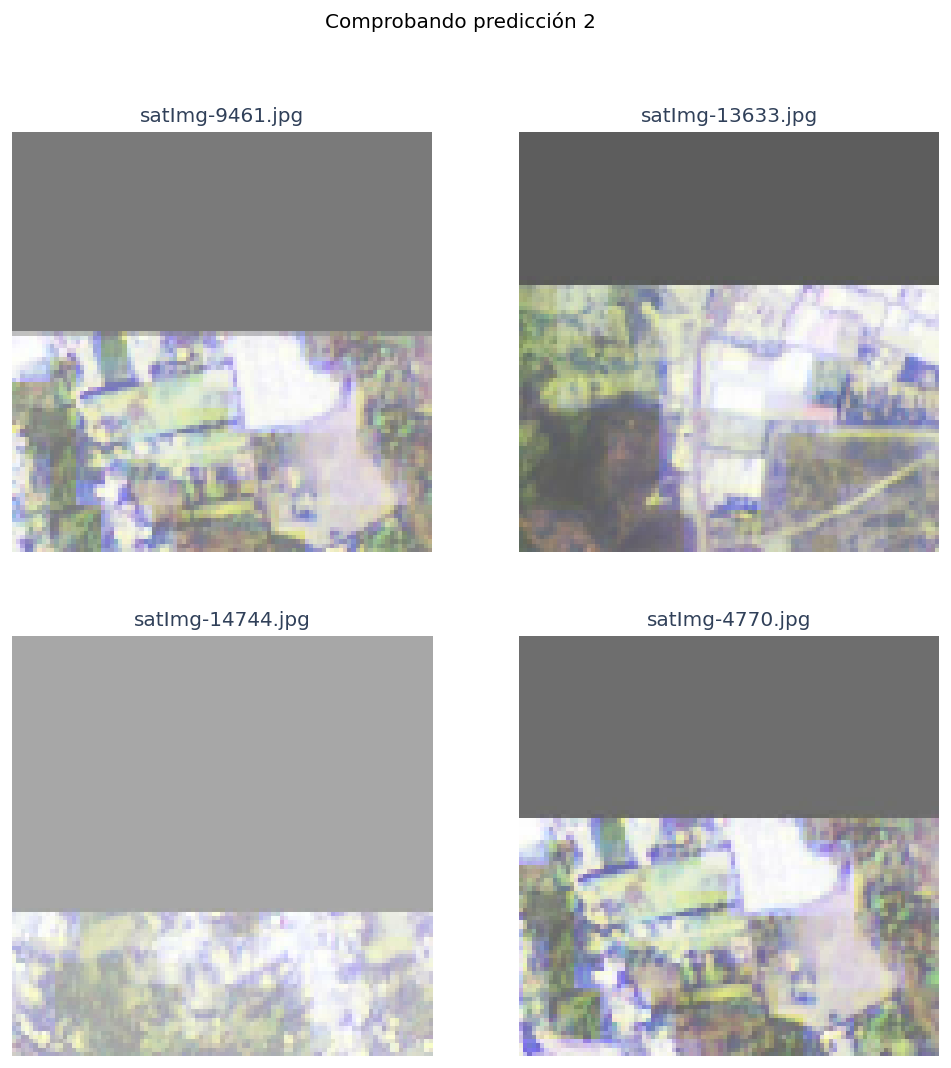

In [61]:
mostrar_imagenes_cluster(image_cluster_ptr, 2, "Comprobando predicción")

In [62]:
#Agregando cluster a total cords
total_cords = total_cords.merge(clusters_df, left_on="ImgName", right_on="imagePath", how="left")
total_cords.head()

,latitude,longitude,ImgName,imagePath,cluster
0,14.60057250,-90.65763472,satImg-19198,satImg-19198,5.00000000
1,14.56675528,-90.46194083,satImg-19129,satImg-19129,6.00000000
2,14.66408722,-90.50296778,satImg-19131,satImg-19131,1.00000000
3,14.61919778,-90.52356722,satImg-19203,satImg-19203,3.00000000
4,14.63808056,-90.49035083,satImg-19135,satImg-19135,0.00000000


In [63]:
print(f"Cantidad de registros sin cluster: {len(total_cords[total_cords['cluster'].isna()])}")
#Imputando valor de anomalía a registros sin cluster
total_cords.loc[total_cords['cluster'].isna(), "cluster"] = [2]*len(total_cords[total_cords['cluster'].isna()])
total_cords[total_cords['cluster'].isna()]

Cantidad de registros sin cluster: 1


,latitude,longitude,ImgName,imagePath,cluster


<AxesSubplot: title={'center': 'Histograma clusters imagenes final'}>

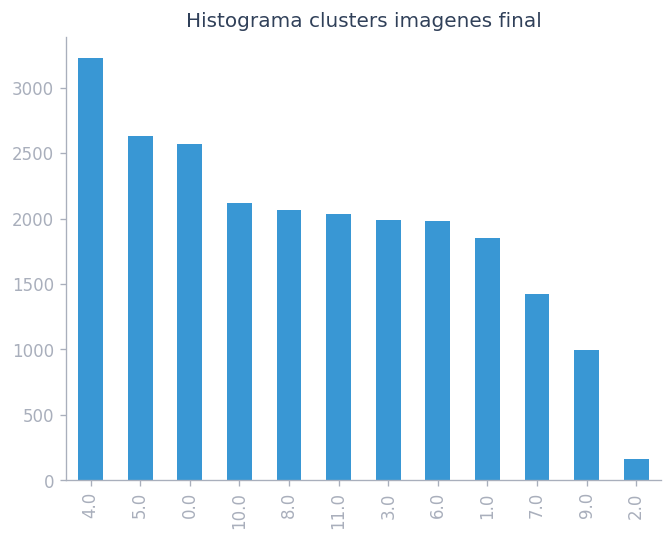

In [64]:
#Visualizando histograma
total_cords['cluster'].value_counts().plot(kind='bar', color = mClr, title = "Histograma clusters imagenes final")

In [65]:
#Imputando imgName y cluster a anomalías (cluster 2)
anomalies = total_cords[total_cords['cluster'] == 2]
normal = total_cords[total_cords['cluster'] != 2]

for index, row in anomalies.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    tdist = normal.apply(lambda x: cord2disV2(lat, lon, x["latitude"], x["longitude"]), axis=1)
    tdist = tdist.sort_values()
    new_imgName = normal.loc[tdist.index[0]]["ImgName"]
    new_cluster = normal.loc[tdist.index[0]]["cluster"]
    anomalies.loc[index, "ImgName"] = new_imgName
    anomalies.loc[index, "cluster"] = new_cluster


print("Anomalías que continúan en cluster 2: {}".format(len(anomalies[anomalies['cluster'] == 2])))

Anomalías que continúan en cluster 2: 0


In [66]:
#Actualizando total cords
total_cords['old_cluster'] = total_cords['cluster']
total_cords['old_ImgName'] = total_cords['ImgName']
total_cords = updateDf(total_cords, anomalies, keyCols = ["latitude","longitude"], updateCols = ["ImgName","cluster"])
total_cords.head()

,latitude,longitude,ImgName,imagePath,cluster,old_cluster,old_ImgName
0,14.60057250,-90.65763472,satImg-19198,satImg-19198,5.00000000,5.00000000,satImg-19198
1,14.56675528,-90.46194083,satImg-19129,satImg-19129,6.00000000,6.00000000,satImg-19129
2,14.66408722,-90.50296778,satImg-19131,satImg-19131,1.00000000,1.00000000,satImg-19131
3,14.61919778,-90.52356722,satImg-19203,satImg-19203,3.00000000,3.00000000,satImg-19203
4,14.63808056,-90.49035083,satImg-19135,satImg-19135,0.00000000,0.00000000,satImg-19135


<AxesSubplot: title={'center': 'Histograma clusters imagenes final - cluster nuevo'}>

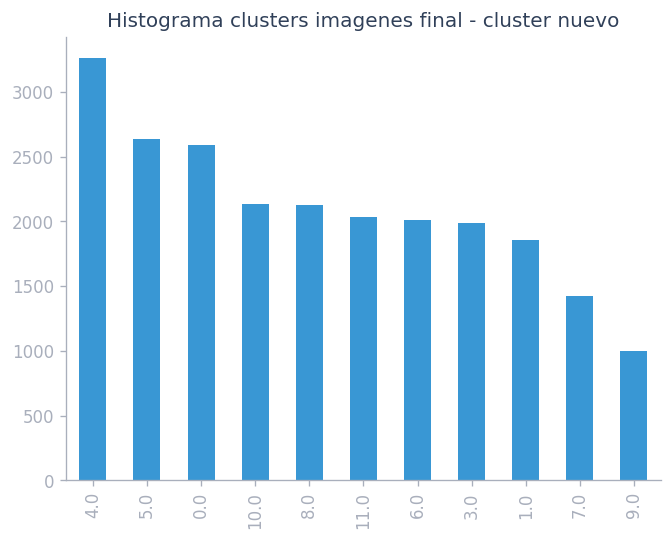

In [67]:
#Graficando histograma con cluster nuevo
total_cords['cluster'].value_counts().plot(kind='bar', color = mClr, title = "Histograma clusters imagenes final - cluster nuevo")

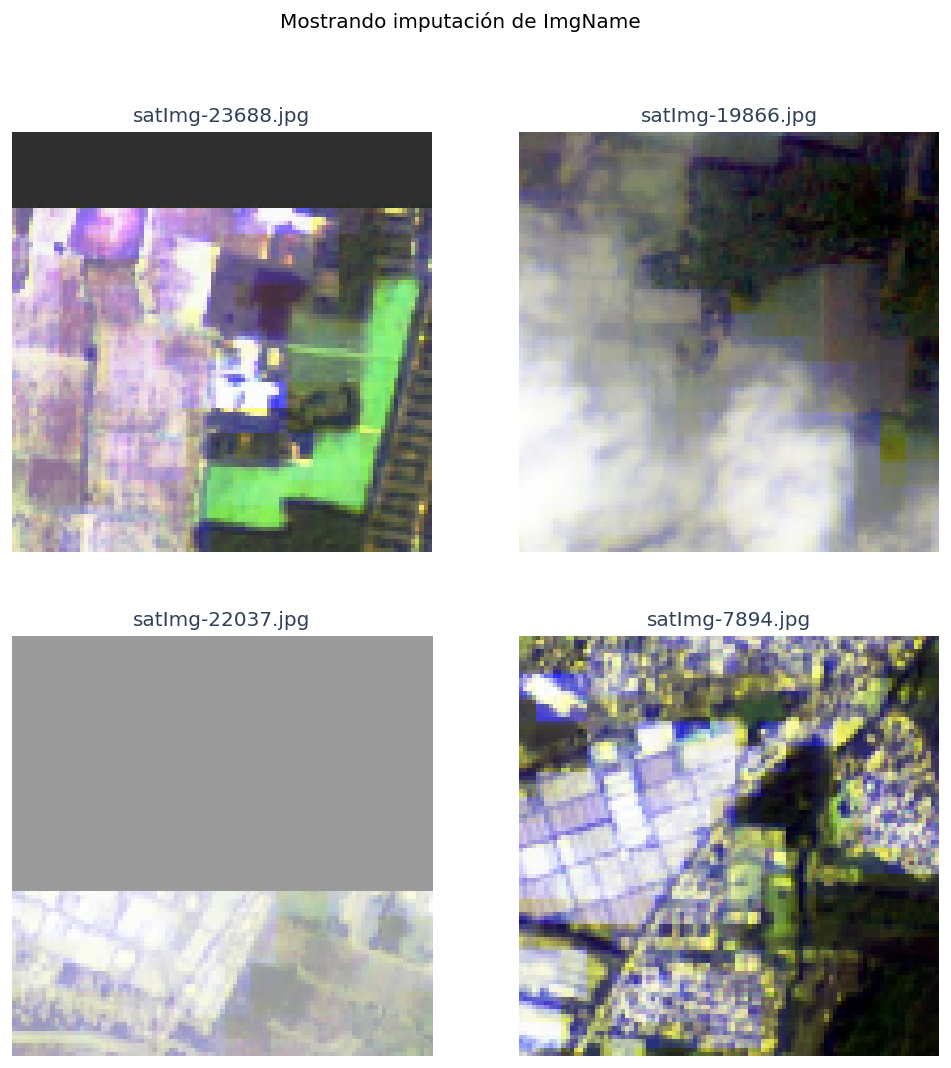

In [68]:
#Visualizando imputaciones de ImgName

to_show_anomalies = total_cords[total_cords['old_ImgName'] != total_cords['ImgName']].sample(2)
to_show_anomalies.reset_index(inplace=True)
to_show_array = [[to_show_anomalies.loc[i, "old_ImgName"], to_show_anomalies.loc[i, "ImgName"]] for i in range(len(to_show_anomalies))]
np.concatenate(to_show_array)
to_show_array = [i+".jpg" for i in np.concatenate(to_show_array)]

plt.figure(figsize=(10, 10))

for i, image_name in enumerate(to_show_array):
    ax = plt.subplot(2, 2, i + 1)
    #Apuntando a directorio
    image_path = f"../../Data/DataMart/transformedImages/{image_name}"
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (99, 99))
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(image_name)
    plt.axis("off")
plt.suptitle("Mostrando imputación de ImgName")
plt.show()


In [69]:
total_cords.to_parquet("../../Data/DataMart/ImageViews/old_clusters_imageName_reference.parquet")
total_cords = total_cords.drop(['imagePath','old_cluster','old_ImgName'], axis =1)

In [70]:
total_cords.to_parquet("../../Data/DataMart/ImageViews/total_cords_final_with_cluster.parquet", index=False)

In [71]:
#Redondeando dfs principales
mesh_gateways['latitude'] = mesh_gateways['latitude'].round(8)
mesh_gateways['longitude'] = mesh_gateways['longitude'].round(8)
temp_mrouter['latitude'] = temp_mrouter['latitude'].round(8)
temp_mrouter['longitude'] = temp_mrouter['longitude'].round(8)
temp_mclient['latitude'] = temp_mclient['latitude'].round(8)
temp_mclient['longitude'] = temp_mclient['longitude'].round(8)

In [72]:
#Agregando imageName y cluster a conjuntos de datos
x_mesh_gateways = mesh_gateways.merge(total_cords, on=["latitude","longitude"], how="left")
x_temp_mrouter = temp_mrouter.merge(total_cords, on=["latitude","longitude"], how="left")
x_temp_mclient = temp_mclient.merge(total_cords, on=["latitude","longitude"], how="left")
#Conteo de nulos
print(f"Cantidad de no ImgName cluster para MG:{len(x_mesh_gateways[x_mesh_gateways['ImgName'].isna()])}")
print(f"Cantidad de no ImgName cluster para MR:{len(x_temp_mrouter[x_temp_mrouter['ImgName'].isna()])}")
print(f"Cantidad de no ImgName cluster para MC:{len(x_temp_mclient[x_temp_mclient['ImgName'].isna()])}")

Cantidad de no ImgName cluster para MG:0
Cantidad de no ImgName cluster para MR:0
Cantidad de no ImgName cluster para MC:0


In [73]:
#Agregando etiqueta de ImgName Imputado a FE-Comments
anomaly_coords = anomalies[["latitude","longitude"]]
list_anomaly_coords = list(zip(anomaly_coords["latitude"],anomaly_coords["longitude"]))
x_mesh_gateways["FE-Comments"] = x_mesh_gateways.apply(lambda x: x["FE-Comments"] + ["ImgName imputed"] if (x["latitude"],x["longitude"]) in list_anomaly_coords else x["FE-Comments"], axis=1)
x_temp_mrouter["FE-Comments"] = x_temp_mrouter.apply(lambda x: x["FE-Comments"] + ["ImgName imputed"] if (x["latitude"],x["longitude"]) in list_anomaly_coords else x["FE-Comments"], axis=1)
x_temp_mclient["FE-Comments"] = x_temp_mclient.apply(lambda x: x["FE-Comments"] + ["ImgName imputed"] if (x["latitude"],x["longitude"]) in list_anomaly_coords else x["FE-Comments"], axis=1)


In [74]:
#Cantidad de imputaciones
impt_mg = len(x_mesh_gateways[x_mesh_gateways['FE-Comments'].apply(lambda x: "ImgName imputed" in x)])
impt_mr = len(x_temp_mrouter[x_temp_mrouter['FE-Comments'].apply(lambda x: "ImgName imputed" in x)])
impt_mc = len(x_temp_mclient[x_temp_mclient['FE-Comments'].apply(lambda x: "ImgName imputed" in x)])
print(f"Cantidad de imputaciones en mesh gateways: {impt_mg}")
print(f"Cantidad de imputaciones en mesh routers: {impt_mr}")
print(f"Cantidad de imputaciones en mesh clients: {impt_mc}")

Cantidad de imputaciones en mesh gateways: 84
Cantidad de imputaciones en mesh routers: 924
Cantidad de imputaciones en mesh clients: 7852


A continuación se presentan los vacíos restantes.

In [75]:
#Columnas con vacíos
cols_empty_mg = x_mesh_gateways.columns[x_mesh_gateways.isna().any()].tolist()
cols_empty_mr = x_temp_mrouter.columns[x_temp_mrouter.isna().any()].tolist()
cols_empty_mc = x_temp_mclient.columns[x_temp_mclient.isna().any()].tolist()
print(f"Columnas con vacíos en mesh gateways: {cols_empty_mg}")
print(f"Columnas con vacíos en mesh routers: {cols_empty_mr}")
print(f"Columnas con vacíos en mesh clients: {cols_empty_mc}")


Columnas con vacíos en mesh gateways: ['onBatteryBackup', 'onBatteryBackupTimeStamp', 'numberOfNeighbors']
Columnas con vacíos en mesh routers: ['altitude', 'numberOfNeighbors', 'DelayToTOPQT', 'HopsQT', 'RSSIQT', 'SNRQT', 'TickPC', 'NeighbourEndpointId', 'LogDTM', 'cDist', 'latitude_neigh', 'longitude_neigh', 'devType', 'dist_neigh']
Columnas con vacíos en mesh clients: ['altitude', 'LastPacketReceived', 'NoCommunicatingDays', 'numberOfNeighbors', 'path', 'mntDate', 'dmntDate', 'mod', 'latitude_gw', 'longitude_gw']


Se determinó que ninguna de las características que continúan teniendo Path son relevantes, o tendrán una imputación que se trabajará posteriormente.

## Depurando columnas

In [76]:
#Visualizando para inspeccionar
x_mesh_gateways.to_csv("../../Data/DataMart/temp/mg_prefinal.csv", index=False)
x_temp_mrouter.to_csv("../../Data/DataMart/temp/mr_prefinal.csv", index=False)
x_temp_mclient.sample(30000).to_csv("../../Data/DataMart/temp/mc_prefinal.csv", index=False)

In [90]:
#Almacenando archivos en Base
x_mesh_gateways.to_parquet("../../Data/DataMart/Base/mg_treated.parquet", index=False)
x_temp_mrouter.to_parquet("../../Data/DataMart/Base/mr_treated.parquet", index=False)
x_temp_mclient.to_parquet("../../Data/DataMart/Base/mc_treated.parquet", index=False)

### Eliminando columnas no necesarias

In [91]:
#Eliminando columnas innecesarias
to_delete_gateways = ['collectorId','onBatteryBackup','onBatteryBackupTimeStamp','fName','Change','Dup','toDelete','Rev','Comment']
x_mesh_gateways.drop(to_delete_gateways, axis=1, inplace=True)
to_delete_routers = ['altitude','poleNo','path','DelayToTOPQT','HopsQT','RSSIQT','SNRQT','TickPC','NeighbourEndpointId','LogDTM','fName',\
                    'latitude_gw','longitude_gw','cDist','neighborSN','serialNumber_neigh','latitude_neigh','longitude_neigh','devType',\
                    'dist_neigh','neigh_outlier','gw_outlier','outlier','n_outliers','g_outliers','outliers','toDelete','Rev','Comment']
x_temp_mrouter.drop(to_delete_routers, axis=1, inplace=True)
to_delete_clients = ['altitude','path','poleNo','fName','Comentario','SStatus','Lote','mntDate','dmntDate','valido','mod','fDate_mr','Desplegado',\
                    'latitude_gw','longitude_gw','CollectorFreq','anomaly','Gw_dist','fixed']
x_temp_mclient.drop(to_delete_clients, axis=1, inplace=True)

In [145]:
y_mesh_gateways = x_mesh_gateways.copy()
y_temp_mrouter = x_temp_mrouter.copy()
y_temp_mclient = x_temp_mclient.copy()

In [146]:
#Conservando solo fechas de time stamp
y_mesh_gateways['LastPacketReceived'] = y_mesh_gateways['LastPacketReceived'].dt.date
y_mesh_gateways['LastStatusChanged'] = y_mesh_gateways['LastStatusChanged'].dt.date
y_temp_mrouter['LastPacketReceived'] = pd.to_datetime(y_temp_mrouter['LastPacketReceived'], unit = 'ms').dt.date
y_temp_mrouter['LastStatusChanged'] = pd.to_datetime(y_temp_mrouter['LastStatusChanged'], unit = 'ms').dt.date
y_temp_mclient['LastPacketReceived'] = pd.to_datetime(y_temp_mclient['LastPacketReceived'], unit = 'ms').dt.date
y_temp_mclient['LastStatusChanged'] = pd.to_datetime(y_temp_mclient['LastStatusChanged'], unit = 'ms').dt.date


In [147]:
#Change column name
y_mesh_gateways.rename(columns = {'StatusCode':'status','DSC':'NoCommunicatingDays'}, inplace = True)
y_temp_mrouter.rename(columns = {'name':'status'}, inplace = True)
#Adding layer to mesh gateways
y_mesh_gateways['layer'] = 0

In [148]:
#Convirtiendo columnas a string
mg_strings = ['radio','serialNumber','CollectorNm','status','fDate','round','ImgName']
mr_strings = ['meterNo','radio','serialNumber','CollectorNm','status','fDate','round','ImgName']
mc_strings = ['meterNo','radio','serialNumber','CollectorNm','status','fDate','round','ImgName']
y_mesh_gateways = y_mesh_gateways.astype({i: 'str' for i in mg_strings})
y_temp_mrouter = y_temp_mrouter.astype({i: 'str' for i in mr_strings})
y_temp_mclient = y_temp_mclient.astype({i: 'str' for i in mc_strings})

In [149]:
#Guardando en Base
y_mesh_gateways.to_parquet("../../Data/DataMart/Base/mg_treated_final.parquet", index=False)
y_temp_mrouter.to_parquet("../../Data/DataMart/Base/mr_treated_final.parquet", index=False)
y_temp_mclient.to_parquet("../../Data/DataMart/Base/mc_treated_final.parquet", index=False)